In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config Completer.use_jedi = False
import astropy.units as u
import astropy.constants as c
import datetime

In [117]:
def Gain(D,freq):
    lam=c.c/(freq)
    A=np.pi*(D/2)**2
    e=1
    G=4*np.pi*e*A/lam**2 # calculate gain (Eq. A)
    return G.cgs

def power(tx,rx,df,rtdb,dl,sig=0.023*u.km**2,tau=(2*u.min).cgs): # from literature
    nametx=rtdb.Name[rtdb.Code==tx].iloc[0] # TX name from code
    namerx=rtdb.Name[rtdb.Code==rx].iloc[0] # RX name from code
    rtx=(df[nametx].to_numpy())*c.R_earth # distance to TX
    rrx=(df[namerx].to_numpy())*c.R_earth # distance to RX
    Dtx=rtdb.Diameter[rtdb.Code==tx].iloc[0]*u.m # TX diameter
    Drx=rtdb.Diameter[rtdb.Code==rx].iloc[0]*u.m # RX diameter
    Tsys=rtdb.Tsys[rtdb.Code==rx].iloc[0]*u.K # system temperature (RX)
    freq=rtdb.Frequency[rtdb.Code==tx].iloc[0]*1e6*u.Hz # transmission freq TX
    Ptx=rtdb.Power[rtdb.Code==tx].iloc[0]*1e3*u.W # transmission power TX
    Gtx=Gain(Dtx,freq) # TX gain
    Grx=Gain(Drx,freq) # RX gain
    Prx=(Ptx*Gtx*Grx*(c.c/(freq))**2*sig/((4*np.pi)**3*rtx**2*rrx**2)).si # calculate Prx (Eq. B)
    PrxdB=10*np.log10((Prx/u.mW).si)  #return Prx in dBm
    Pratio=(Prx/Ptx).si  #return TX/RX power ratio

    time=pd.to_datetime(dl.date)
    dt=(time.iloc[1]-time.iloc[0]).total_seconds()*u.s # time increment in dl
    lon=(dl.lonR.to_numpy())*u.deg.to(u.rad) # sub-radar longitude to radians
    lat=(dl.latR.to_numpy())*u.deg.to(u.rad) # sub-radar latitude to radians
    x=np.sin(lat)*np.cos(lon) # unit vector coord x
    y=np.sin(lat)*np.sin(lon) # unit vector coord y
    z=np.cos(lat) # unit vector coord z
    pointing=np.vstack((x,y,z)).T # unit vector of subradar pointing
    dtheta=np.arccos((pointing[1:]*pointing[:-1]).sum(axis=1)) # change in angle from moment to moment
    omega=dtheta/dt # angular frequency
    period=2*np.pi/omega # return rotation period
    rotfreq=1/period # rotation frequency
    phi=lat[1:] # subradar latitude
    bw=4*np.pi*np.cos(phi)*370*u.m/((c.c/freq)*period) # Doppler bandwidth (Eq. C)
    Nrms=(Tsys*c.k_B*np.sqrt(bw/tau)) # rms noise power (Eq. D)
    SNR=(Prx[1:]/Nrms).si # return signal-to-noise ratio 
    return PrxdB, Pratio, SNR, omega, nametx,namerx

def power_plots(PrxdB, Pratio, SNR, omega, nametx,namerx,df,tx,rx):
    title='TX: '+nametx+'; RX: '+namerx
    # dBm plot
    plt.figure(dpi=150)
    plt.plot(df.datetime_jd-df.datetime_jd.min(),PrxdB)
    plt.xlabel("JD-"+str(df.datetime_jd.min()))
    plt.ylabel("Prx (dBm)")
    plt.savefig('dBm'+tx+'_'+rx+'.png')
    plt.title(title)
    plt.show()
    # Power ratio plot
    plt.figure(dpi=150)
    plt.semilogy(df.datetime_jd-df.datetime_jd.min(),Pratio)
    plt.xlabel("JD-"+str(df.datetime_jd.min()))
    plt.ylabel("Prx/Ptx ")
    plt.savefig('Pratio'+tx+'_'+rx+'.png')
    plt.title(title)
    plt.show()
    # SNR plot
    plt.figure(dpi=150)
    plt.semilogy((df.datetime_jd-df.datetime_jd.min())[1:],SNR)
    plt.xlabel("JD-"+str(df.datetime_jd.min()))
    plt.ylabel("SNR")
    plt.savefig('SNR'+tx+'_'+rx+'.png')
    plt.title(title)
    plt.show()

    # rotation period plot
    plt.figure(dpi=150)
    plt.plot((df.datetime_jd-df.datetime_jd.min())[1:],(omega*(180/np.pi)).to(u.h**-1))
    plt.xlabel("JD-"+str(df.datetime_jd.min()))
    plt.ylabel("Angular frequency (deg/hour)")
    plt.savefig('angfreq.png') # the same for all telescope pairs
    plt.title(title)
    plt.show()

In [118]:
df=pd.read_csv("observatory_distances.csv")
rtdb=pd.read_excel('AllRadiotelescopes.xlsx')
dl=pd.read_csv('subradar_points.csv')

In [119]:
print([i for i in rtdb.Code])

['ARE', 'GOL', 'GBI', 'GBT', 'G1F', 'VLA', 'VLB', 'FAS', 'CDS', 'ECD', 'TSU', 'USU', 'GRE', 'OKI', 'MAS', 'KAT', 'BIS', 'KAM', 'UCH']


In [120]:
tx='GOL'
rx='ARE'

In [121]:
PrxdB, Pratio, SNR, omega, nametx,namerx= power(tx,rx,df,rtdb,dl)

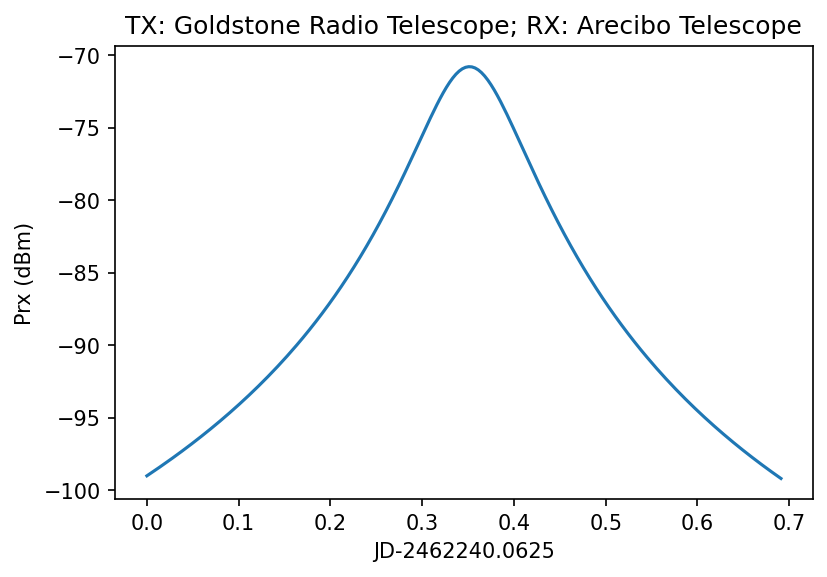

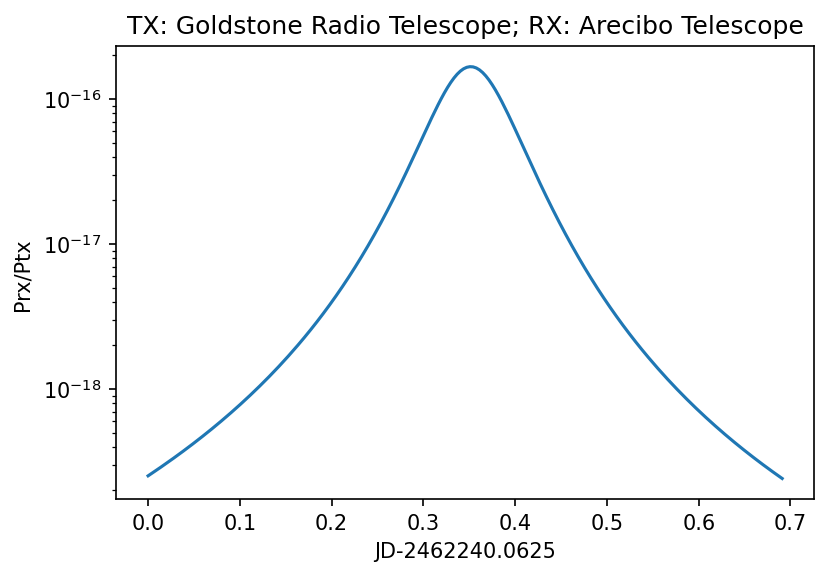

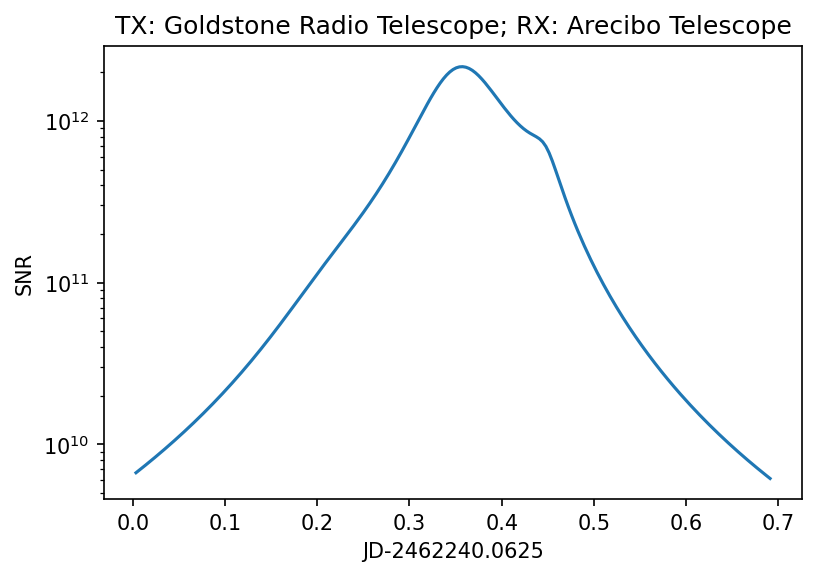

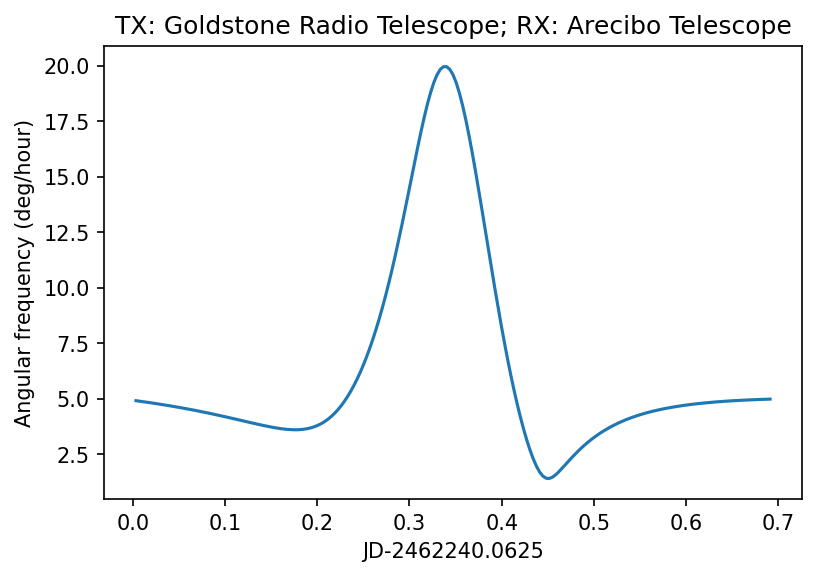

In [122]:
power_plots(PrxdB, Pratio, SNR, omega, nametx,namerx,df,tx,rx)

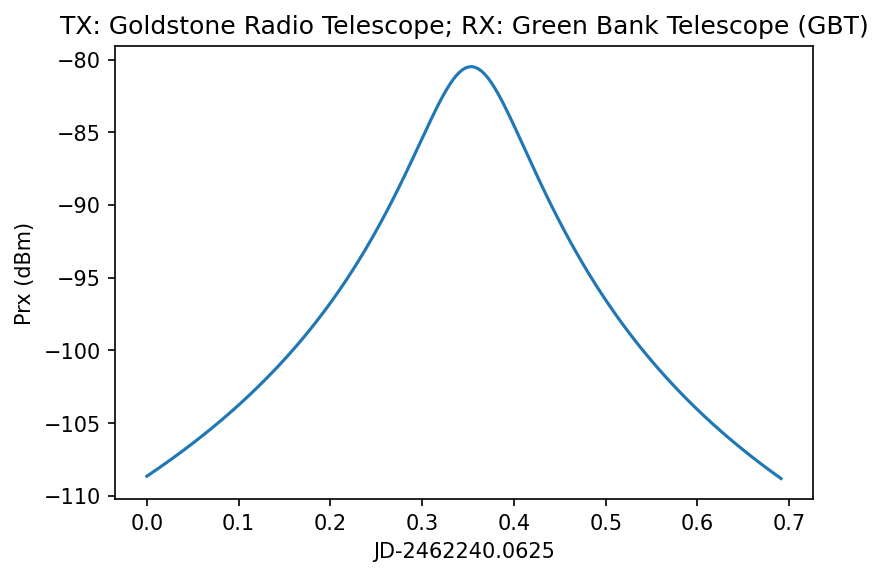

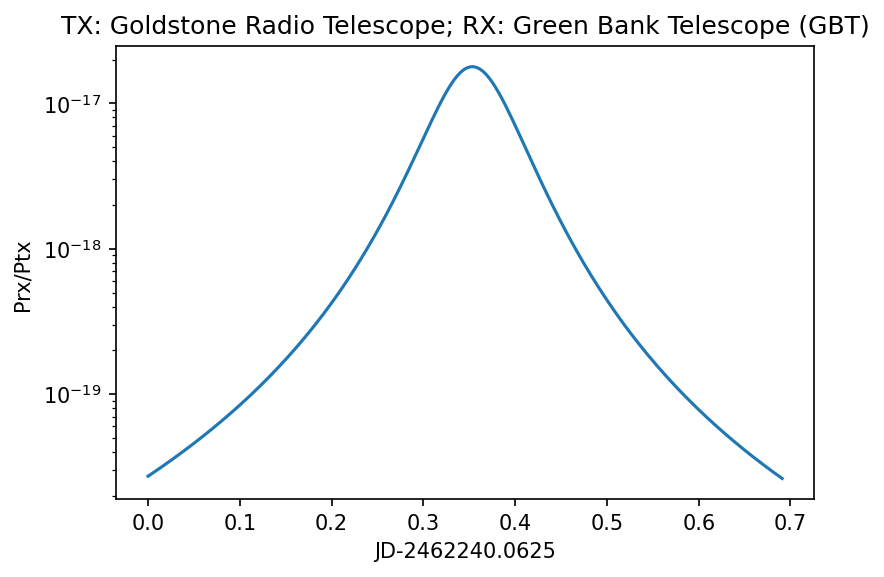

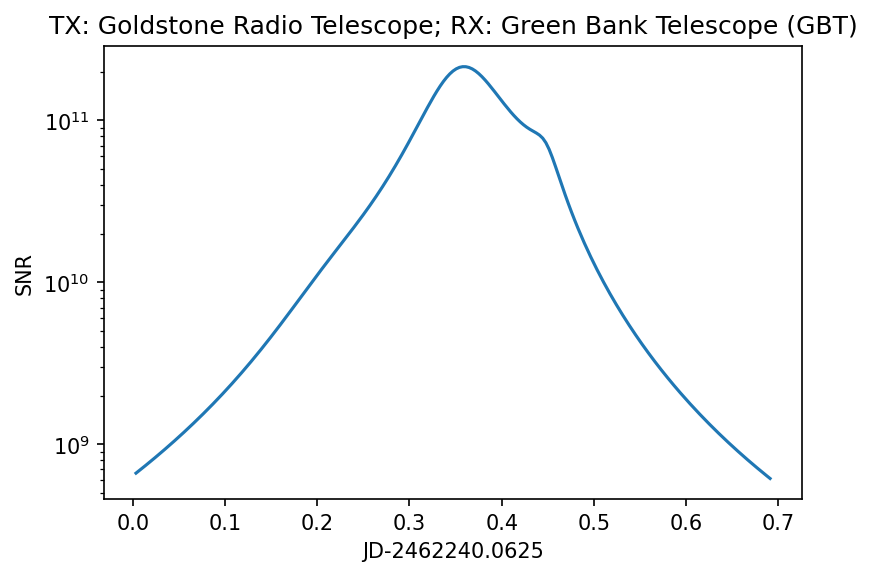

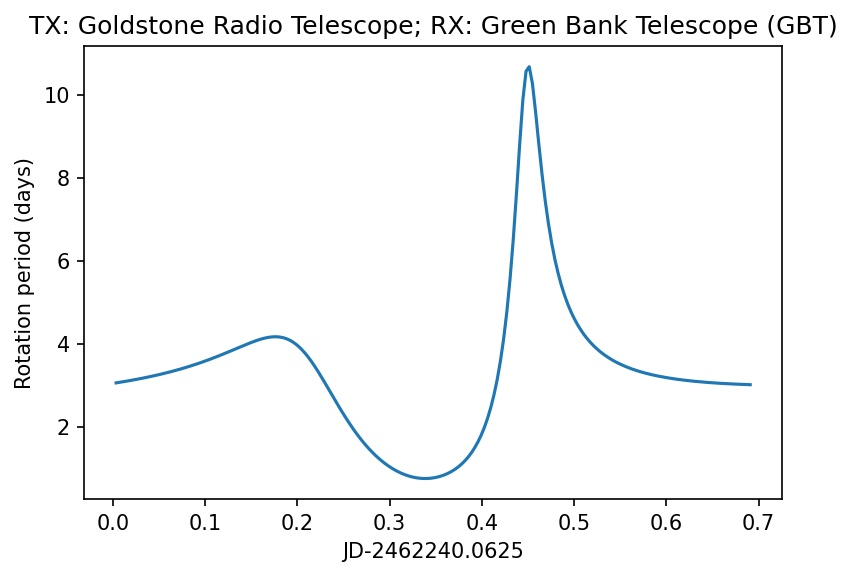

In [79]:
tx='GOL'
rx='GBT'
PrxdB, Pratio, SNR, period, nametx,namerx= power(tx,rx,df,rtdb,dl)
power_plots(PrxdB, Pratio, SNR, period, nametx,namerx,df,tx,rx)

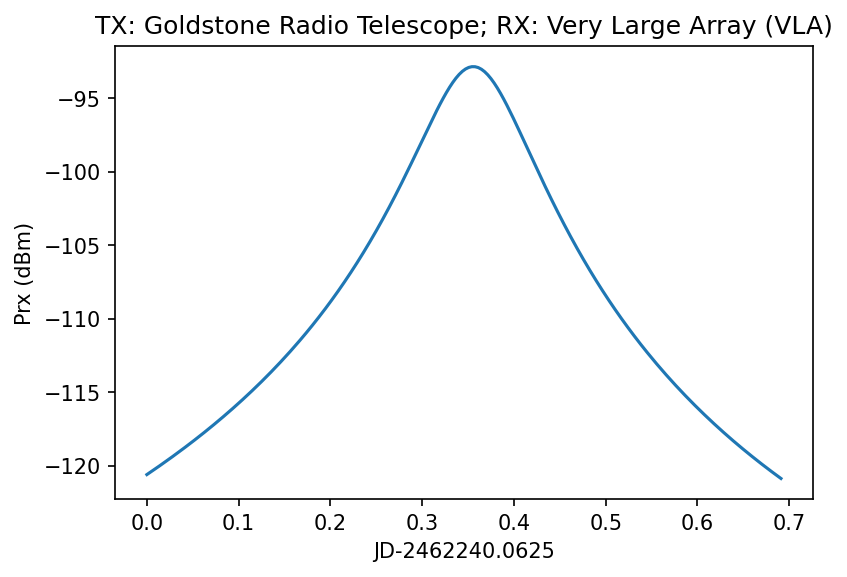

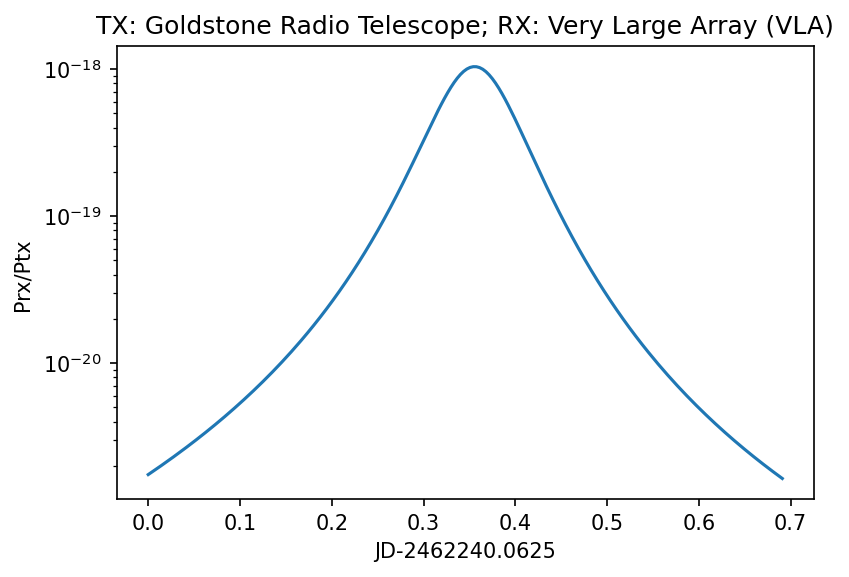

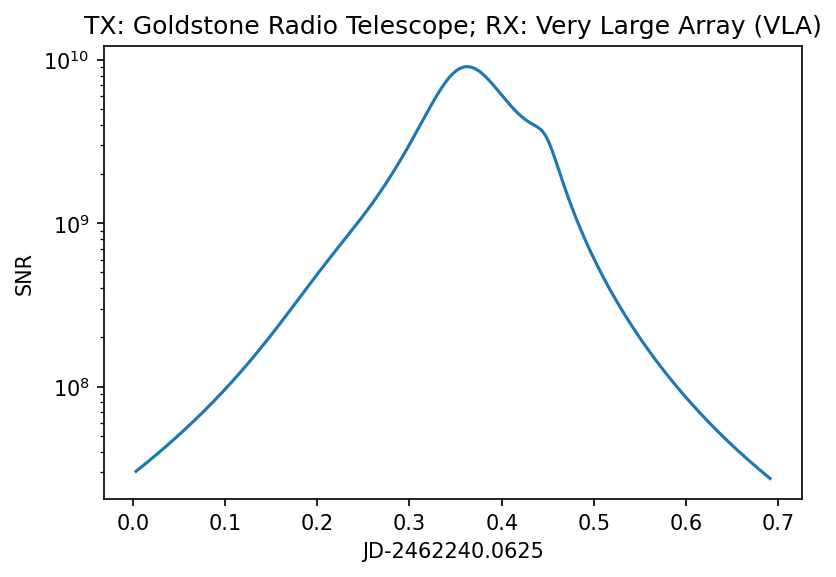

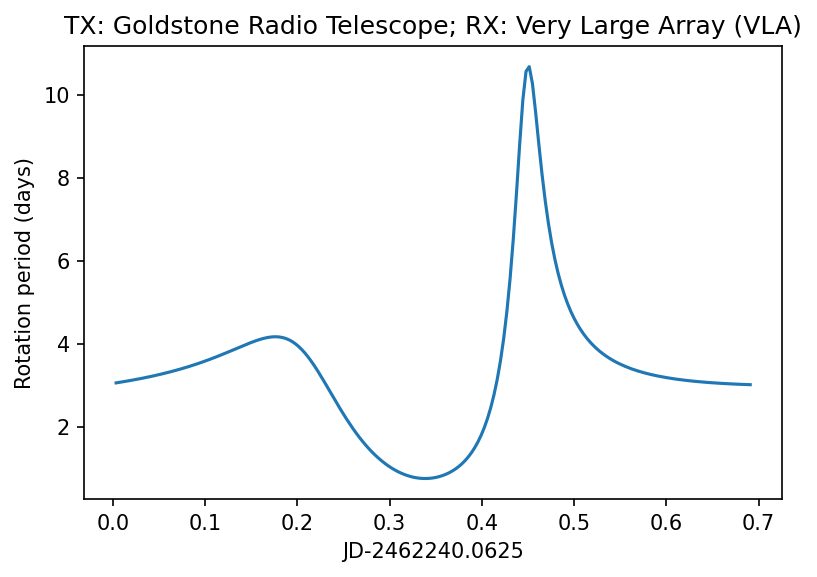

In [80]:
tx='GOL'
rx='VLA'
PrxdB, Pratio, SNR, period, nametx,namerx= power(tx,rx,df,rtdb,dl)
power_plots(PrxdB, Pratio, SNR, period, nametx,namerx,df,tx,rx)

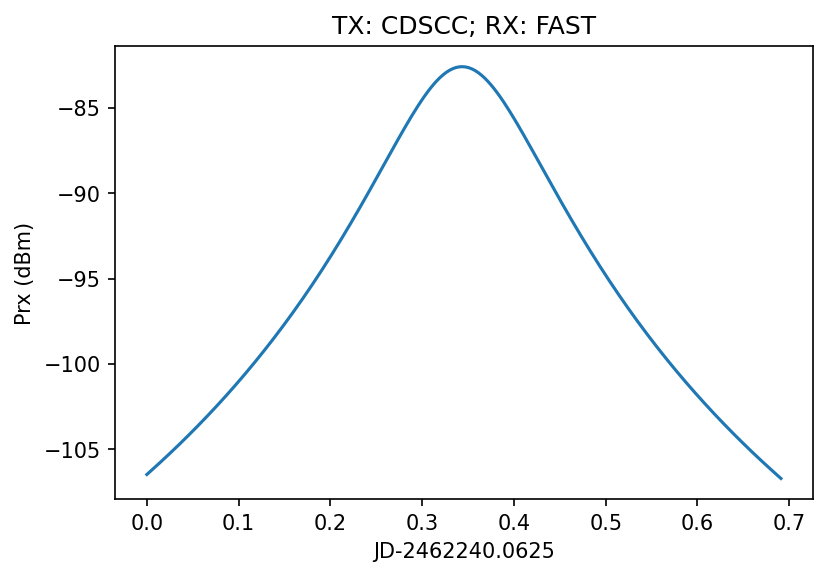

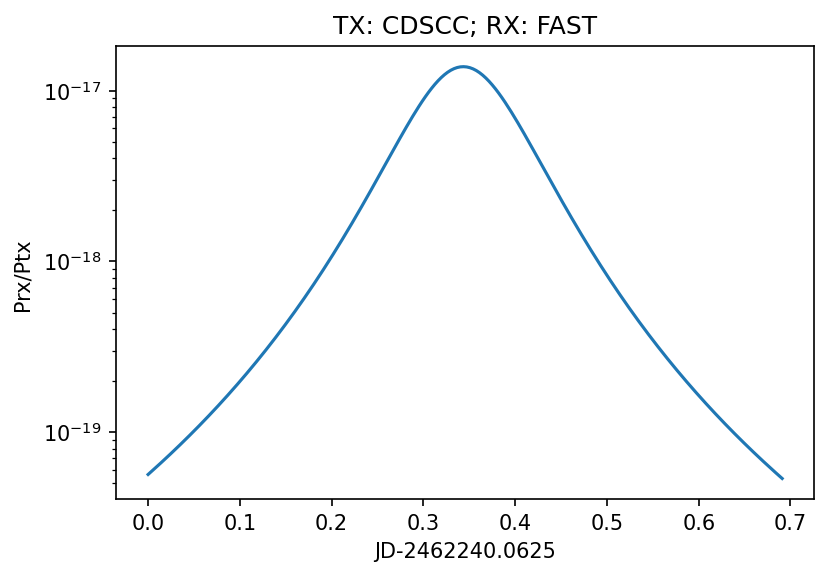

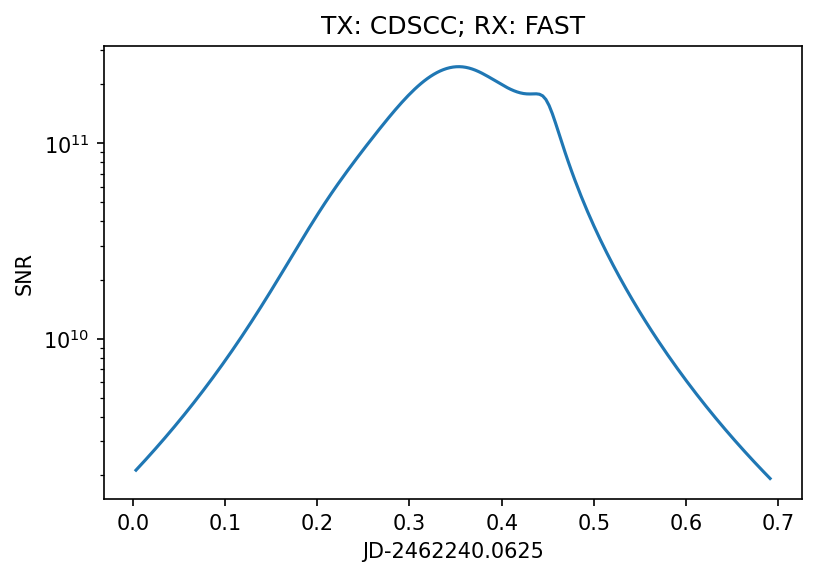

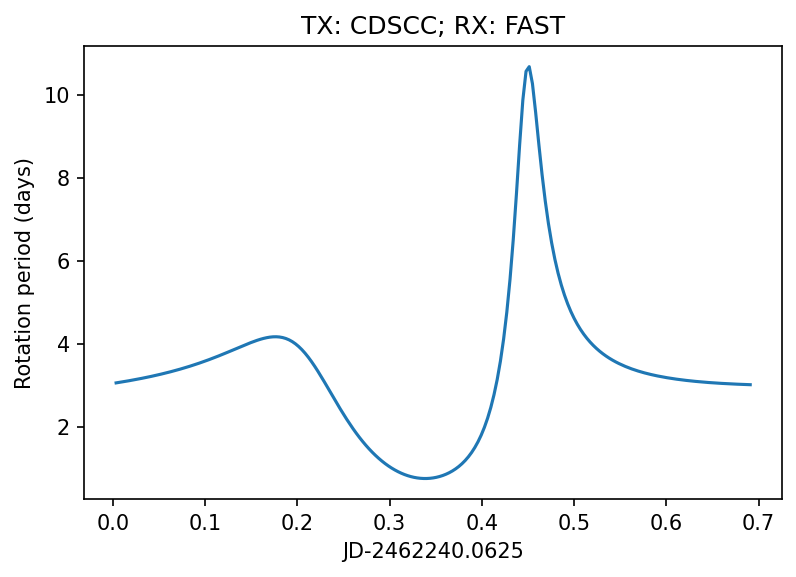

In [81]:
tx='CDS'
rx='FAS'
PrxdB, Pratio, SNR, period, nametx,namerx= power(tx,rx,df,rtdb,dl)
power_plots(PrxdB, Pratio, SNR, period, nametx,namerx,df,tx,rx)

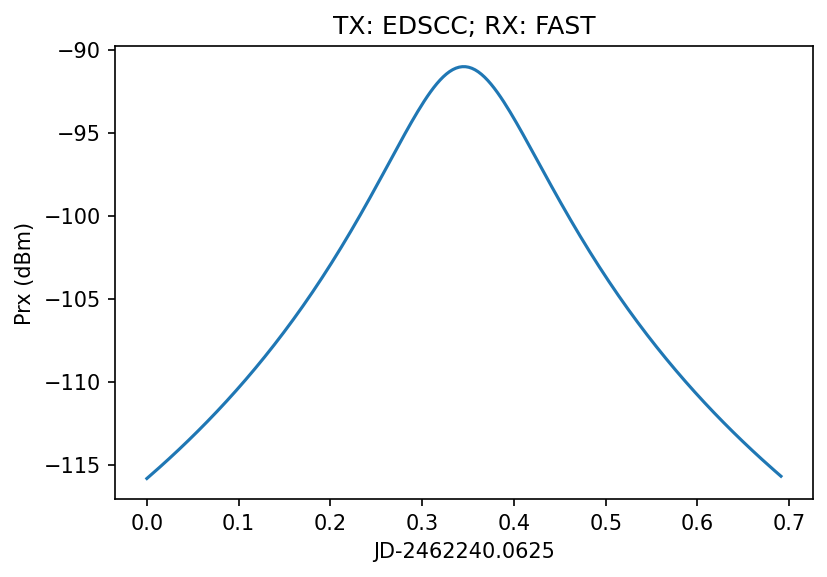

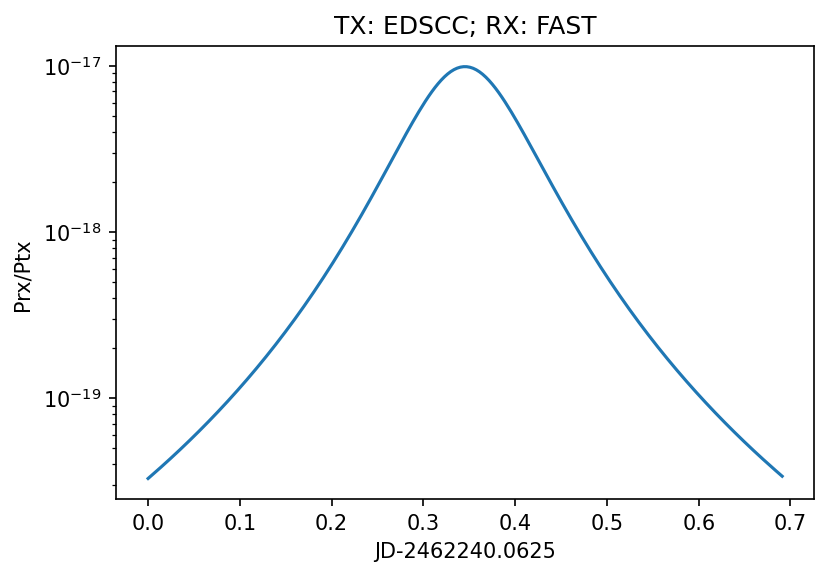

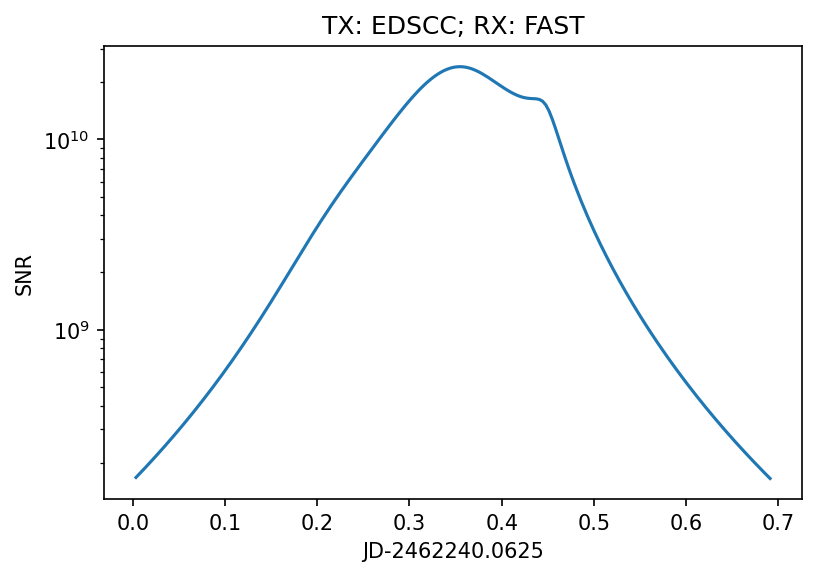

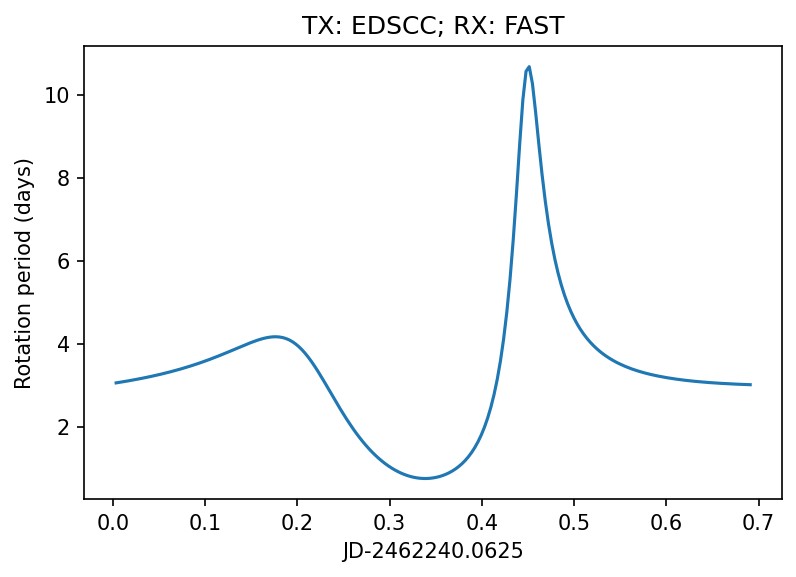

In [82]:
tx='ECD'
rx='FAS'
PrxdB, Pratio, SNR, period, nametx,namerx= power(tx,rx,df,rtdb,dl)
power_plots(PrxdB, Pratio, SNR, period, nametx,namerx,df,tx,rx)